In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#

Mounted at /content/drive


In [ ]:
path_to_file = '/content/drive/MyDrive/Colab Notebooks/SIC/data/'

In [250]:
import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

In [258]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_y = pd.read_csv("test_labels.csv").fillna(' ')
submission = pd.read_csv('sample_submission.csv')

#just take the first 60000 rows
train = train[:60000]
test = test[:60000]

In [260]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [34]:
test_y.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


# Pre-processing data

In [245]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# this function receives comments and returns clean word-list
def clean_doc(text_record):
    # split tokens by white space
    tokens = text_record.split()
    # remove punctuation from each string
    table = str.maketrans({key: None for key in string.punctuation})
    tokens = [token.translate(table) for token in tokens]
    # remove tokens that are not alphabetic
    tokens = [token for token in tokens if token.isalpha()]
    # convert letters to lower case
    
    tokens = [token.lower() for token in tokens]
    #stem tokens
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token.lower()) for token in tokens]
   # tokens = stemmer.stem(tokens.lower())
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # remove short words (one letter)
    tokens = [token for token in tokens if len(token) > 1]
    # lemmatization
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(token,"v") for token in tokens]
    sentence = ' '.join(tokens)
    return sentence

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [262]:
processed_train = train['comment_text'].apply(lambda x: clean_doc(x))
processed_test  = test['comment_text'].apply(lambda x: clean_doc(x))
#processed_test_y = test_y['comment_text'].apply(lambda x: pre_process_text(x))

In [268]:
print(processed_train)

0        explan whi edit make usernam hardcor metallica...
1        daww match thi background colour im seemingli ...
2        hey man im realli tri edit war thi guy constan...
3        cant make ani real suggest improv wonder secti...
4                           sir hero ani chanc rememb page
                               ...                        
59995    havent read thi book heinlein children juvenil...
59996    consid aid worker intern countri effect also s...
59997                                 lista green corneliu
59998    peni peni peni peni peni peni peni peni peni p...
59999                                  apolog past conduct
Name: comment_text, Length: 60000, dtype: object


In [270]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.096950,0.010067,0.052783,0.003417,0.049367,0.008683
std,0.295892,0.099827,0.223603,0.058353,0.216634,0.092780
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Visualize wordcloud data

In [273]:
from wordcloud import WordCloud, STOPWORDS
def wordplot (column, text):
  comments = train['comment_text'].loc[column == 1].values
  word_cloud = WordCloud( width = 940, height = 540, background_color = 'white',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the

  fig = plt.figure( figsize = (8, 5))
  plt.subplot()
  plt.imshow(word_cloud, interpolation = 'bilinear')
  plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "black")
  plt.tight_layout(pad = 0)
  plt.axis('off')
  plt.show()

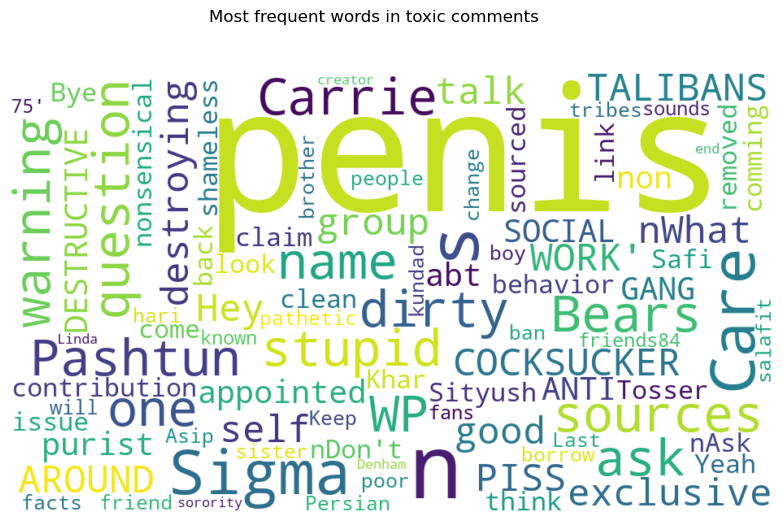

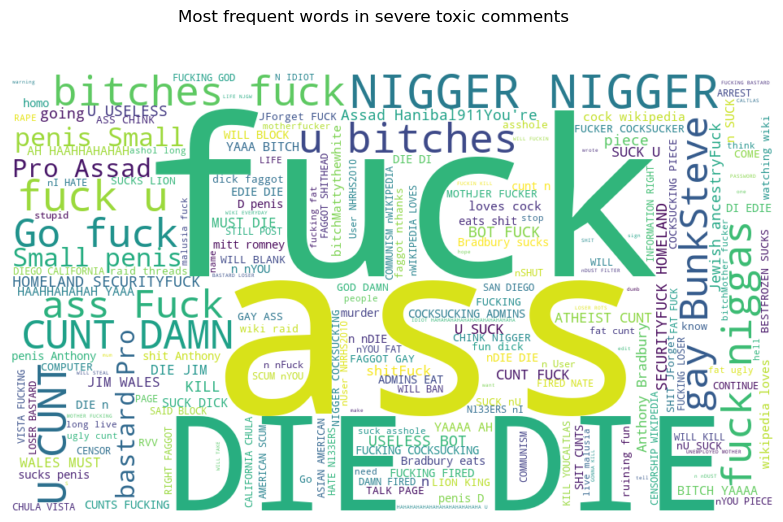

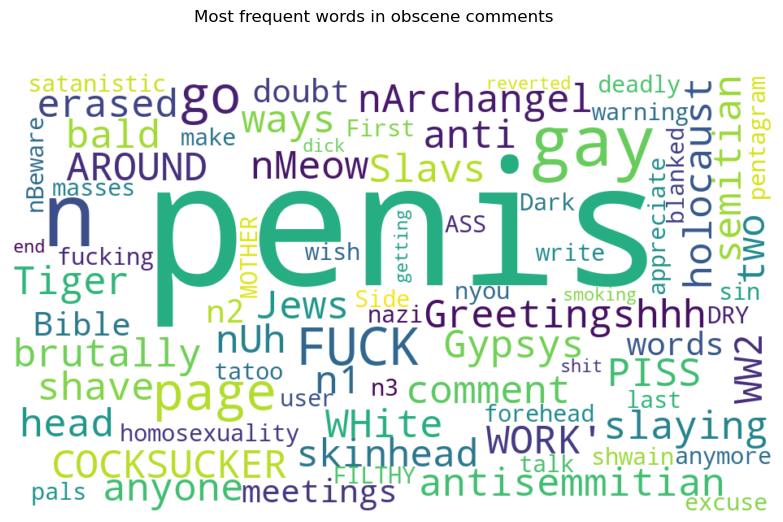

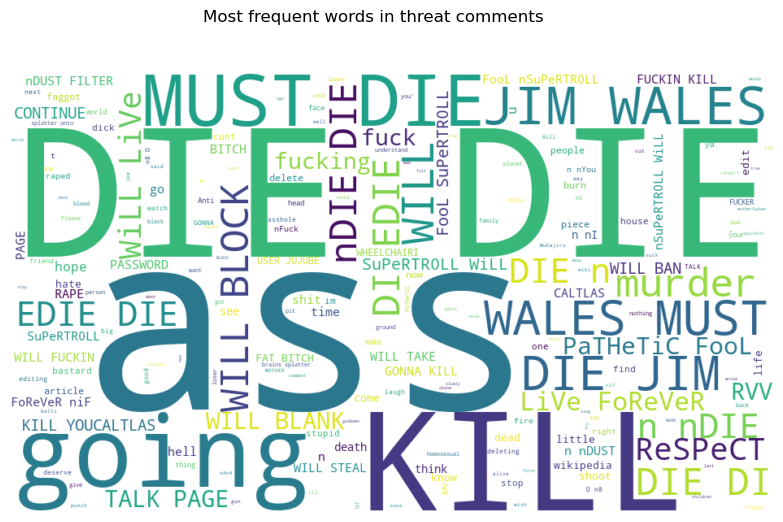

In [275]:
wordplot(train['toxic'], 'toxic comments')
wordplot(train['severe_toxic'], 'severe toxic comments')
wordplot(train['obscene'], 'obscene comments')
wordplot(train['threat'], 'threat comments')

<ipython-input-14-4013a442976a>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)


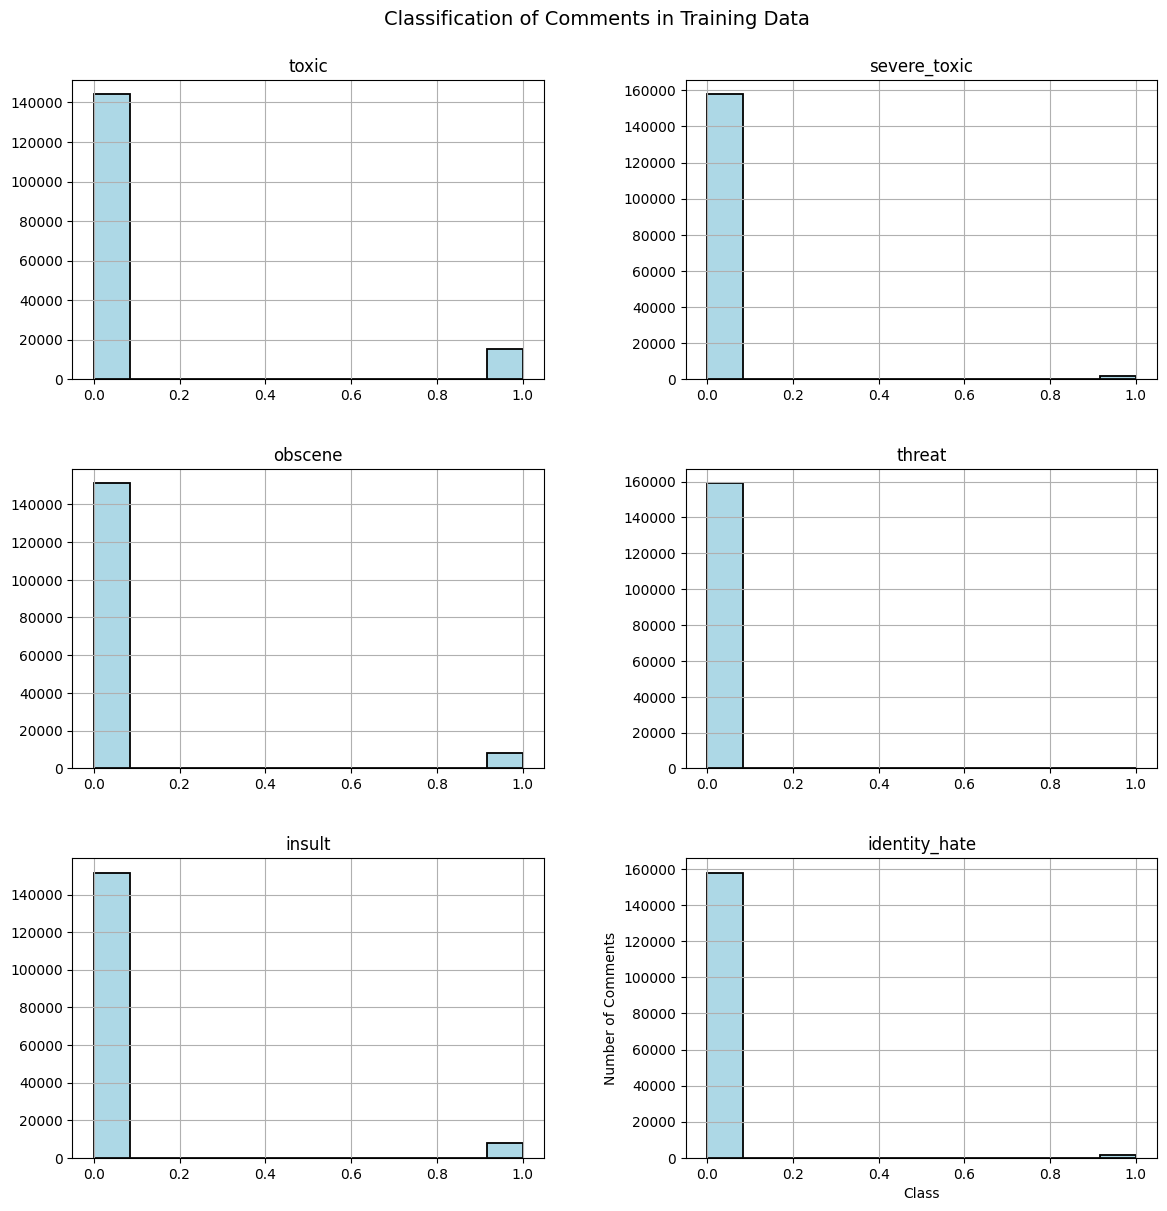

In [ ]:
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
train.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Classification of Comments in Training Data',y = 0.93,size = 14)
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.show()

# Word embedding Using TF-IDF


In [277]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf = True,
    strip_accents = 'unicode',
    analyzer = 'word',
    token_pattern = r'\w{1,}',
    stop_words = 'english',
    ngram_range = (1, 6),
    max_features = 20000)

word_vectorizer.fit(processed_train)
train_features = word_vectorizer.transform(processed_train)
test_features = word_vectorizer.transform(processed_test)

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Y_features = train[class_names]
X_features = train_features
X_train_features, X_val_features, y_train_features, y_val_features = train_test_split(X_features, Y_features, test_size=0.3, random_state=30)

In [278]:
# calculate Precision, recall, ROC

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
def calculateEvalMetrics(Y_test,y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    y_score = np.asarray(y_score)


    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                         average="micro")

    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    roc_val = roc_auc_score(Y_test,y_score)
    print("ROC : {}".format(roc_val*100))

    print('Average ROC score, micro-averaged over all toxicity levels: {}'
          .format(roc_auc["micro"] *100))

    plt.figure()
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
    'Average precision score, micro-averaged over all toxicity levels: {0:0.2f}'
    .format(average_precision["micro"]))



In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle
from numpy import interp
def plotROC(y_test,y_score):
    class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    n_classes = 6
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_score = np.asarray(y_score)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC for multiple classes')
    plt.legend(loc="lower right")
    plt.show()

In [279]:
def plotPrecisionRecallCurve(model, x_test, y_test) :
    from sklearn.metrics import precision_recall_curve
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    probabilities = model.predict_proba(x_test)
    skplt.metrics.plot_precision_recall(y_test, probabilities)
    plt.show()

In [ ]:
#Calculate Hamming and Log Loss
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
|
def evaluate_score(Y_test,predict):
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try :
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))

In [ ]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.2 MB/s eta 0:00:00


In [294]:
#function to predict comment
def predict_comment(comment: str, model):
    comment = np.array([comment])
    vectorize = word_vectorizer.transform(comment).toarray()
    res = classifier.predict(vectorize).toarray().reshape(1,-1)
    return pd.DataFrame(res, columns=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'])

# Logistics regression

Start fit...
End fit...
Start predict...
End predict...
Hamming_loss : 3.2740740740740746
Accuracy : 87.43888888888888
Log_loss : 0.8503516329069224
Average precision score, micro-averaged over all classes: 0.45
ROC : 86.23536804875637
Average ROC score, micro-averaged over all toxicity levels: 89.30996909672658


D:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


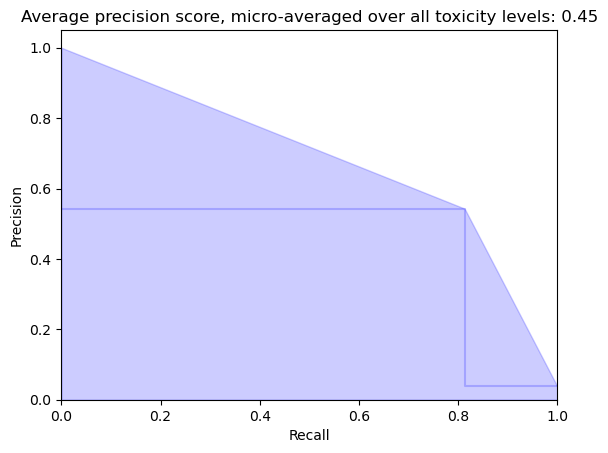

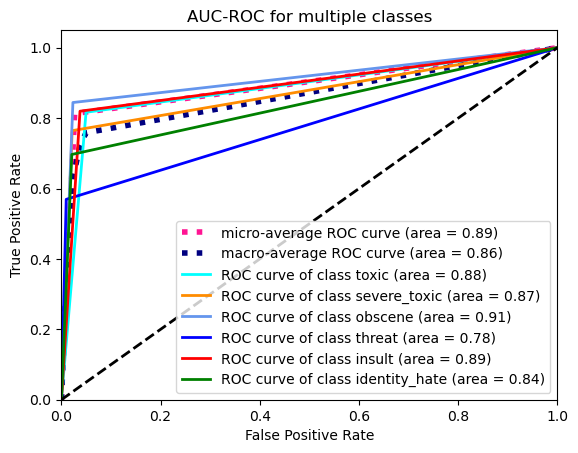

In [283]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

classifier = BinaryRelevance(classifier=LogisticRegression(class_weight='balanced', max_iter=1000),
                             require_dense=[False, True])

print("Start fit...")
classifier.fit(X_train_features, y_train_features)
print("End fit...")

print("Start predict...")
predictions = classifier.predict(X_val_features)
print("End predict...")

# Evaluate the model using your evaluation functions
evaluate_score(y_val_features, predictions)
calculateEvalMetrics(np.asarray(y_val_features), predictions.todense())
plotROC(np.asarray(y_val_features), predictions.todense())
# plotPrecisionRecallCurve(classifier, X_val_features, y_val_features)  # Uncomment if you need this



In [317]:
predict_comment('stupid', classifier)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,1,1,0,1,1


# SVM

Start fit...
End fit...
Start predict...
End predict...
Hamming_loss : 3.532336229946524
Accuracy : 85.4382520053476
Log_loss : 0.9350485598517883


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Average precision score, micro-averaged over all classes: 0.44
ROC : 84.60204578540993
Average ROC score, micro-averaged over all toxicity levels: 89.91147547940025


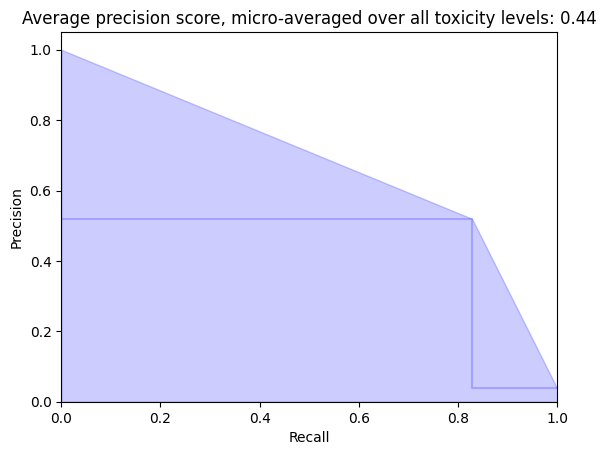

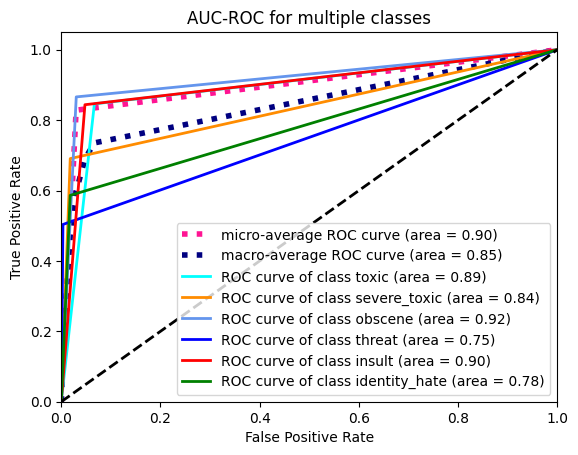

In [ ]:
#SVM Classifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

classifier = BinaryRelevance(classifier = SVC(kernel='linear',class_weight='balanced'), require_dense = [False, True])
print("Start fit...")
classifier.fit(X_train_features, y_train_features)
print("End fit...")
print("Start predict...")
predictions = classifier.predict(X_val_features)
print("End predict...")
evaluate_score(y_val_features,predictions)
calculateEvalMetrics(np.asarray(y_val_features),predictions.todense())
plotROC(np.asarray(y_val_features),predictions.todense())
#plotPrecisionRecallCurve(classifier, X_val_features, y_val_features)

In [315]:
predict_comment('i want to kill you', classifier)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,0,0,1,1,0


# MultinomialNB

Start fit...
End fit...
Start predict...
End predict...
Hamming_loss : 4.07962962962963
Accuracy : 89.01666666666667
Log_loss : 1.89153472573068
Average precision score, micro-averaged over all classes: 0.15


D:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


ROC : 58.23361203092009
Average ROC score, micro-averaged over all toxicity levels: 63.25062912329624


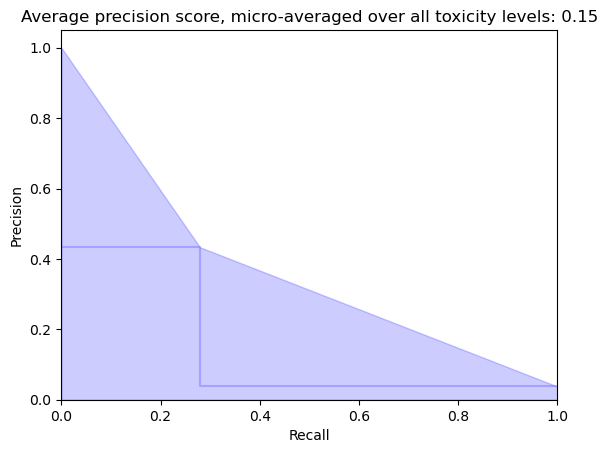

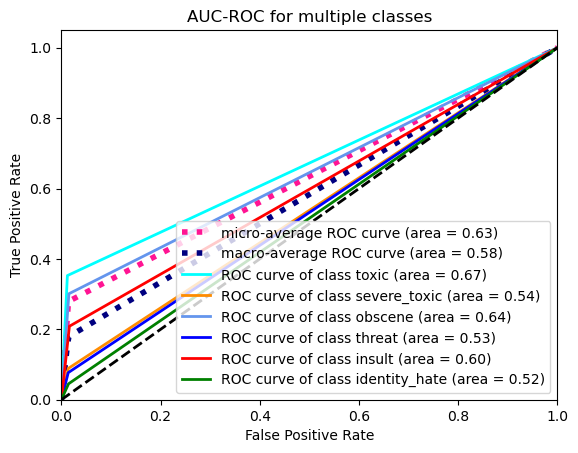

In [281]:
#Multinomial Naive Bayes
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
classifier = BinaryRelevance(classifier = MultinomialNB(), require_dense = [False, True])
print("Start fit...")
classifier.fit(X_train_features, y_train_features)
print("End fit...")
print("Start predict...")
predictions = classifier.predict(X_val_features)
print("End predict...")
evaluate_score(y_val_features,predictions)
calculateEvalMetrics(np.asarray(y_val_features),predictions.todense())
plotROC(np.asarray(y_val_features),predictions.todense())
#plotPrecisionRecallCurve(classifier, X_val_features, y_val_features)

In [313]:
predict_comment('holy shit', classifier)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,1,1,0,1,0


# XGBoosting

Start fit...
End fit...
Start predict...
End predict...
Hamming_loss : 2.041555258467023
Accuracy : 91.62558489304813
Log_loss : 1.3851241390313862


D:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Average precision score, micro-averaged over all classes: 0.49
ROC : 70.04764388335914
Average ROC score, micro-averaged over all toxicity levels: 77.16150703058807


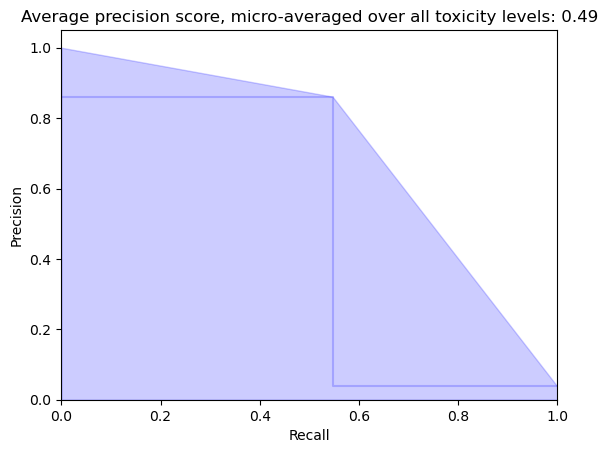

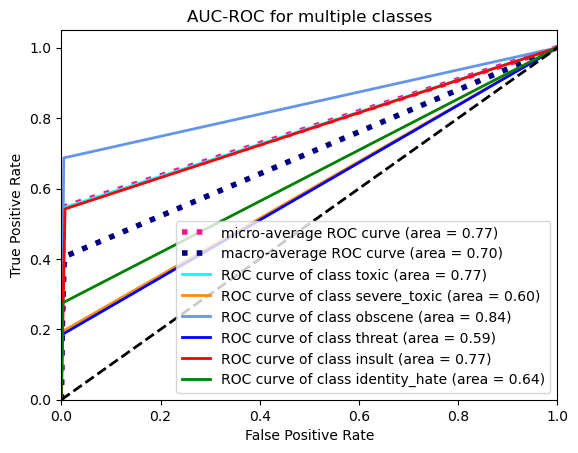

In [214]:
#XGBoost
from skmultilearn.problem_transform import BinaryRelevance
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
classifier = BinaryRelevance(classifier = XGBClassifier(n_jobs=-1, max_depth=4, scale_pos_weight=1), require_dense = [False, True])
print("Start fit...")
classifier.fit(X_train_features, y_train_features)
print("End fit...")
print("Start predict...")
predictions = classifier.predict(X_val_features)

print("End predict...")
evaluate_score(y_val_features,predictions)
calculateEvalMetrics(np.asarray(y_val_features),predictions.todense())
plotROC(np.asarray(y_val_features),predictions.todense())
#plotPrecisionRecallCurve(classifier)

In [309]:
predict_comment('cock sucker', classifier)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,1,1,0,1,1


# Word embedding using GloVe


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-08-22 14:26:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-22 14:26:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-22 14:26:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [57]:
max_features = 20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(processed_train)
train_encoded = tokenizer.texts_to_sequences(processed_train)
test_encoded = tokenizer.texts_to_sequences(processed_test)

#vocabulary size
print('The vocabulary size is {}.'.format(len(tokenizer.word_index)))

#print("tokenizer items -->",tokenizer.word_index.items())

#length of comment
print("length of encoded comments-->",len(train_encoded))
print(train_encoded[0])
print("length of encoded comments-->",len(train_encoded))
print(train_encoded[0])

The vocabulary size is 228904.
length of encoded comments--> 159571
[526, 44, 47, 518, 4402, 11227, 924, 209, 1915, 10673, 6321, 2486, 2643, 37, 1014, 15061, 2678, 5, 9, 137, 302, 4, 2, 58, 13, 3218]
length of encoded comments--> 159571
[526, 44, 47, 518, 4402, 11227, 924, 209, 1915, 10673, 6321, 2486, 2643, 37, 1014, 15061, 2678, 5, 9, 137, 302, 4, 2, 58, 13, 3218]


In [59]:
#get equal length vectors for all the comments
maxlen = 250
X_train = pad_sequences(train_encoded, maxlen = maxlen, padding = 'post')
X_test = pad_sequences(test_encoded, maxlen = maxlen, padding = 'post')

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train[class_names]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=30)

In [68]:
def create_embeddings_index(filename):
    embeddings_index = dict()
    f = open(filename, encoding = 'utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index.keys()))
    return embeddings_index

In [63]:
def create_embeddings_matrix(tokenizer, embeddings_index):
   # print("Word index",tokenizer.word_index)
    vocab_size = len(tokenizer.word_index) + 1
    embeddings_matrix = np.zeros((vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embeddings_vector = embeddings_index.get(word)
        if embeddings_vector is not None:
            embeddings_matrix[i] = embeddings_vector
    #print(embeddings_matrix)
    return embeddings_matrix

# GloVe model

In [80]:
embeddings_index_glove = create_embeddings_index('rajesh/pre_trained/glove.6B.100d.txt')
embeddings_matrix_glove = create_embeddings_matrix(tokenizer, embeddings_index_glove)
print(embeddings_matrix_glove)

Loaded 400000 word vectors.
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.55660999 -0.11523     0.32071999 ... -1.15799999  0.58295
   0.34836999]
 [-0.92940003  0.10925    -0.021222   ... -0.92944002  0.63875002
   0.38077   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.07574     0.42109001  0.77687001 ...  0.095977    1.62820005
  -0.10819   ]
 [ 0.068997   -0.31268999 -0.24092001 ... -0.06305     0.52090001
   0.45936   ]]


# LSTM 

In [86]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
#from keras.layers.convolutional import Conv1D, MaxPooling1D
# define the model
vocab_size = len(tokenizer.word_index) + 1

model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 100, weights = [embeddings_matrix_glove], trainable = False))
model_glove.add(Bidirectional(LSTM(128, return_sequences=True)))
model_glove.add(GlobalMaxPool1D())
model_glove.add(Dropout(0.25))
model_glove.add(Dense(6, activation="sigmoid"))

In [88]:
class roc_callback(Callback):
    from sklearn.metrics import f1_score
    def __init__(self,training_data,validation_data):

        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)


        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)

        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')


        # For each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        y_test = np.asarray(y_val)
        y_score = np.asarray(y_pred_val)


        for i in range(len(class_names)):
            precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                                y_score[:, i])
            average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])


        # A "micro-average": quantifying score on all classes jointly
        precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
            y_score.ravel())
        average_precision["micro"] = average_precision_score(y_test, y_score,
                                                             average="micro")

        print('Average precision score, micro-averaged over all classes: {0:0.2f}'
              .format(average_precision["micro"]))

        #print(y_pred_val)
        #y_pred_val_np = np.argmax(y_pred_val, axis=1)
        #evaluate_score(np.asarray(y_val),y_pred_val_np)
        #calculateEvalMetrics(np.asarray(y_val),y_pred_val_np.todense())
        plotROC(np.asarray(y_val),y_pred_val)
        return

# Train LSTM

In [90]:
# function that compile, train and evaluate model
def train_model(model,X_train,y_train,X_val,y_val,batch_size,epochs,filepath):
    # compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # parameters
    batch_size = batch_size
    epochs = epochs


    # callbacks
    checkpointer =  ModelCheckpoint(filepath=filepath,
                                    verbose=1,
                                    save_best_only=True)
    roc = roc_callback(training_data=(X_train,y_train),validation_data=(X_val,y_val))
    print("ROC Callback o/p",roc)
    # fit the model
    history = model.fit(X_train,y_train,
                        validation_data=(X_val,y_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[roc,checkpointer])
    # load the model with the best validation loss
    model.load_weights(filepath)
    return model, history

ROC Callback o/p <__main__.roc_callback object at 0x000001E398BC5670>
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step
roc-auc: 0.9707 - roc-auc_val: 0.9691                                                                                                    
Average precision score, micro-averaged over all classes: 0.78


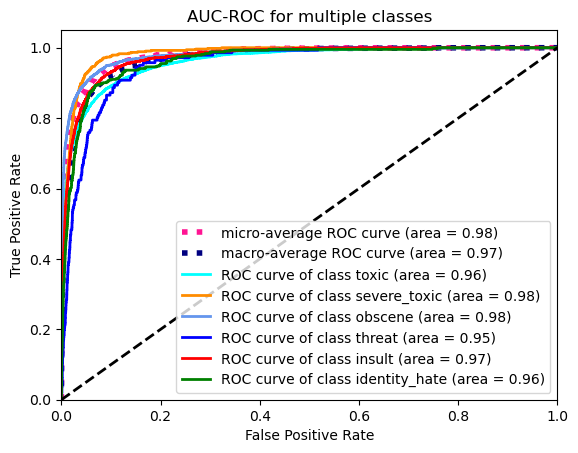


Epoch 1: val_loss improved from inf to 0.05739, saving model to saved_models/weights.best.glove.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.9093 - loss: 0.0646 - val_accuracy: 0.9900 - val_loss: 0.0574


In [116]:
model_glove_trained, history_glove = train_model(model_glove,
                                     X_train,y_train,
                                     X_val,y_val,
                                     batch_size=512,
                                     epochs=1,
                                     filepath='saved_models/weights.best.glove.keras')

In [307]:
predict_comment('cock sucker', model_glove_trained)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,1,1,0,1,1
